
## Simple 2conv Arch
![Drag Racing](figs/res2conv.png)

- New cnn with two conv layers (24 +n_input) trainable parameter.



- 4 configs:
   + uv 
   + uv dxy
   + uv(t,t+1)   ---> by doing this, we are sure that we are no learning advection in fixed frame
   + uv(t,t+1) dxy


```_________________________________________________________________________
Layer                  Type               Output Shape        Param #     RF
=============================================================================
convresidualnet          ConvResidualNet    (-1, 1, 366, 230)      0       5              
├─initial_layer          Conv2d             (-1, 1, 366, 230)      2       5              
|    └─0                 ConvResidualBlock  (-1, 1, 366, 230)      20      5              
├─final_layer            Conv2d             (-1, 1, 366, 230)      2       1              
============================================================================
Trainable params: 24 + n_input
Non-trainable params: 0
Total params: 24 + n_input


```





Load beautiful theme

In [1]:
#!jt -l
!jt -t grade3


Load your libs


In [1]:
from scipy.special import rel_entr
import numpy as np
import torch
import numpy as np
import xarray as xr
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.reset_defaults()
sns.set_context("talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2

Create class for the simulations


In [2]:
class sim:
    def __init__(self, name, tloss, vloss, bloss):
        self.name  = name
        self.tloss = tloss
        self.vloss = vloss
        self.bloss = bloss

Load all the simulations (2conv_uv_dxy_2 stands for the second run of 2conv_uv_dxy, the first run did stuck in a alocal minimum)

In [3]:
simulations={'2conv_uv','2conv_uv2','2conv_uv_dxy_2', '2conv_uv2_dxy', 'res_uv', 'res_uv_dxy' }
data_path= '/home/anas/MEOM_Workspace/data/models/snapshot/UNet/'
sims=[]

for simulation in simulations:
    name=simulation
    #print(data_path + name + 'loss.txt')
    edata= pd.read_csv(data_path + name + '/loss.txt', sep=",")
    bdata= pd.read_csv(data_path + name + '/Bloss.txt')
    tloss=edata["train_loss"]
    vloss=edata["val_loss"]
    bloss=bdata
    #print(bloss.shape)
    sims.append(sim(name,tloss,vloss,bloss))

Plot Train vs Val for all simulations 

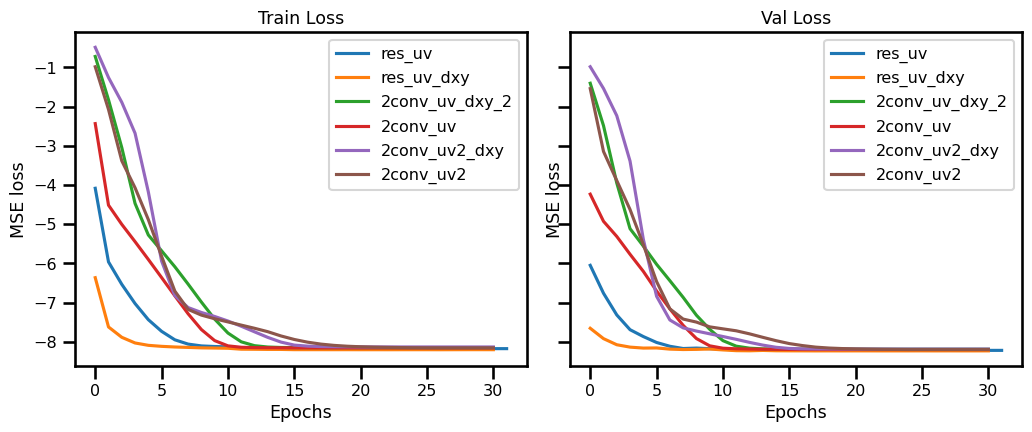

In [4]:
plt.rcParams["figure.figsize"] = [10.50, 4.50]
norm = 0.43405532837#sims[0].tloss.values[0]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
for sim in sims:
        ax1.plot(np.log(sim.tloss/norm),label=sim.name)
        ax2.plot(np.log(sim.vloss/norm),label=sim.name)

ax1.title.set_text('Train Loss')
ax1.set_ylabel('MSE loss')
ax1.set_xlabel('Epochs')
ax1.legend()

ax2.title.set_text('Val Loss')
ax2.set_ylabel('MSE loss')
ax2.set_xlabel('Epochs')
ax2.legend()            
plt.tight_layout()
plt.show()

Define a function that arranges dynamic plotting

Plot Train/Val of each simulation

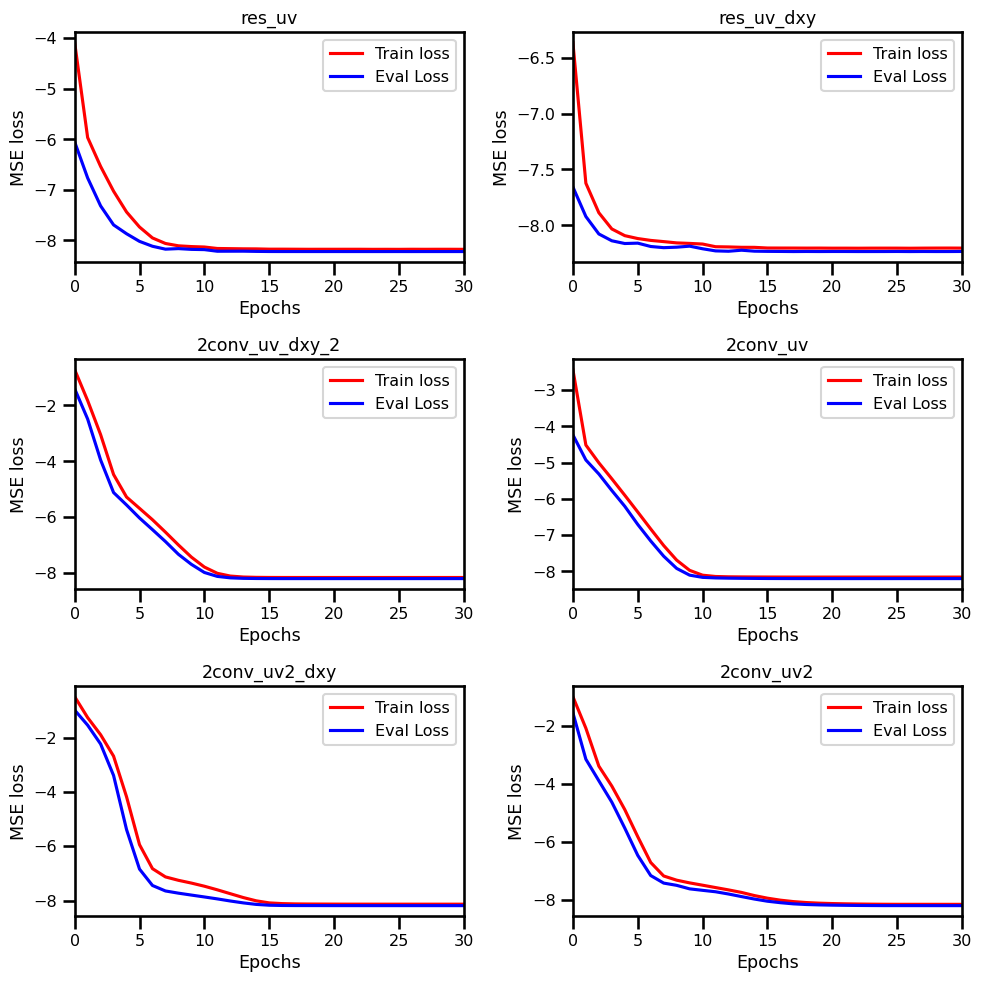

In [5]:
# norm = sims[0].tloss.values[0]   
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10,10))
axs = axs.ravel()
# def demo_plot_and_yield():
for iax, sim in zip(axs, sims):
    # yield
    iax.plot(np.log(sim.tloss/norm),'r',np.log(sim.vloss/norm),'b')
    iax.set_ylabel('MSE loss')
    iax.set_xlabel('Epochs')
    # axs[i].gca().legend(('Train loss','Eval loss'))
    iax.set_title(sim.name)
    iax.set_xlim(0, 30)
    iax.legend(["Train loss", "Eval Loss"])


# multiplot_from_generator(demo_plot_and_yield(), 2)
plt.tight_layout()
plt.show()

In [6]:
# uncomment to generate map videos 
#import os

#for sim in sims:
#    print('processing', sim.name)
#    os.system('python make_video.py '+ data_path + sim.name + '/maps.nc '+ 'video/'+ sim.name + '.gif')
#print('done')

    

In [7]:
# uncomment to visualize the evolution of maps
#from IPython.display import display, Markdown, Latex
#for sim in sims:
#    gifpath='video/' + sim.name+'.gif'
#    display(Markdown('# Config '+sim.name))
#    display(Markdown('![alt text]('+gifpath+')'))



7


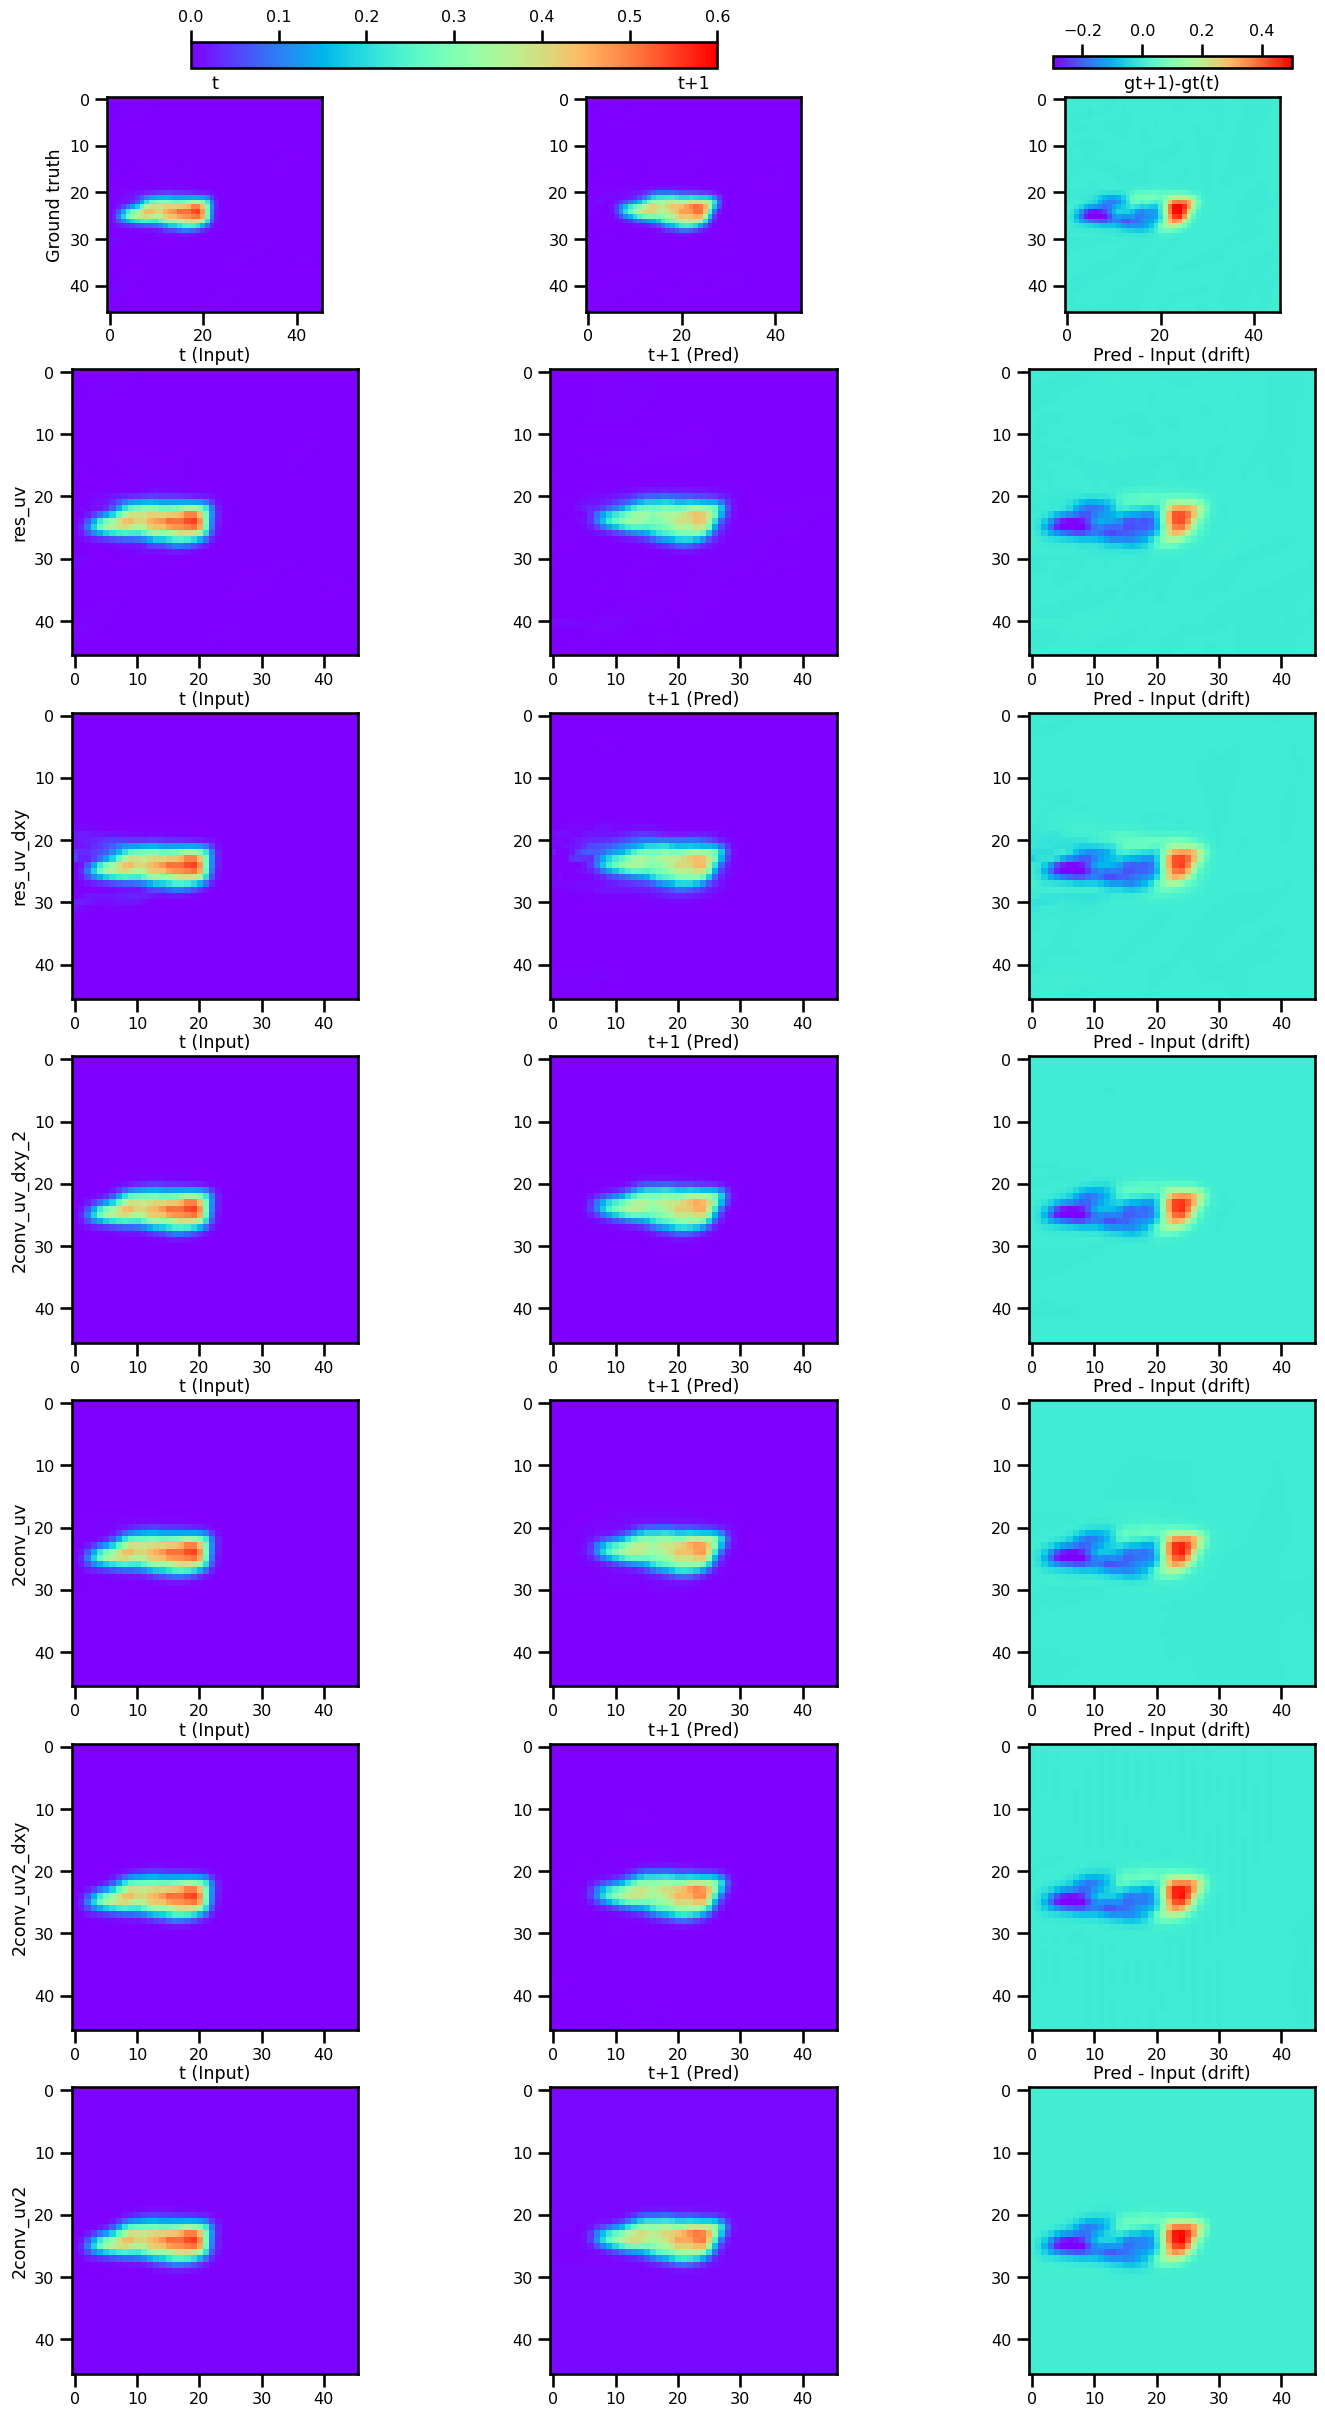

In [8]:

sims1=sims.copy()
sims1.insert(0,sims[0])
print(len(sims1))
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

j=10
file_in= data_path + sims1[0].name + '/maps.nc'
nc1 = xr.open_dataset(file_in)
x = nc1.density_map_gt.values[j,0,:,:]
ind = np.unravel_index(np.argmax(x, axis=None), x.shape)
#print([1:1:10])


plt.rcParams["figure.figsize"] = [17.50, 30.50]
#plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(len(sims1), 3)

""" Iterate column's axes"""
def iterate_columns(cols, x,ind,i, name):
    k=23
    mmax=0.6
    if i==0:
        
        
        im=cols[0].imshow(x.density_map_gt.values[j,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k], 
                       cmap=cm.rainbow, vmin=0, vmax=mmax)
        #fig.colorbar(im, ax=cols[0], location = "top")
        cols[0].title.set_text('t')
        cols[0].set_ylabel('Ground truth')
        cols[1].imshow(x.density_map_gt.values[j+1,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],
                       cmap=cm.rainbow, vmin=0, vmax=mmax)
        cols[1].title.set_text('t+1')
        fig.colorbar(im, ax=cols[:2], shrink=0.6, location='top',pad=0.1)

        im=cols[2].imshow(x.density_map_gt.values[j,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k]
                       -x.density_map_gt.values[j-1,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],
                       cmap=cm.rainbow, vmin=-0.3, vmax=0.5)
        cols[2].title.set_text('gt+1)-gt(t)')
        fig.colorbar(im, ax=cols[2], shrink=0.6, location='top',pad=0.1)

    else:
        cols[0].imshow(x.density_map_gt.values[j,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],
                       cmap=cm.rainbow, vmin=0, vmax=mmax)
        cols[0].title.set_text('t (Input)')
        cols[0].set_ylabel(name)
        cols[1].imshow(x.density_map_ml.values[j+1,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],
                        cmap=cm.rainbow, vmin=0, vmax=mmax)
        cols[1].title.set_text('t+1 (Pred)')
        cols[2].imshow(x.density_map_ml.values[j+1,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k]
                       -x.density_map_gt.values[j,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],
                        cmap=cm.rainbow, vmin=-0.3, vmax=0.5)
        cols[2].title.set_text('Pred - Input (drift)')
        

    
""" Iterate row's axes"""
i=0
for row in axes:
    file_in= data_path + sims1[i].name + '/maps.nc'
    nc1 = xr.open_dataset(file_in)
    nc1.density_map_ml.values[j+1,0,:,:]=nc1.density_map_ml.values[j+1,0,:,:]
    iterate_columns(row, nc1, ind, i, sims1[i].name)
    i=i+1
    
nc1 = xr.open_dataset(file_in)
x = nc1.density_map_ml.values[j,0,:,:]

plt.show()



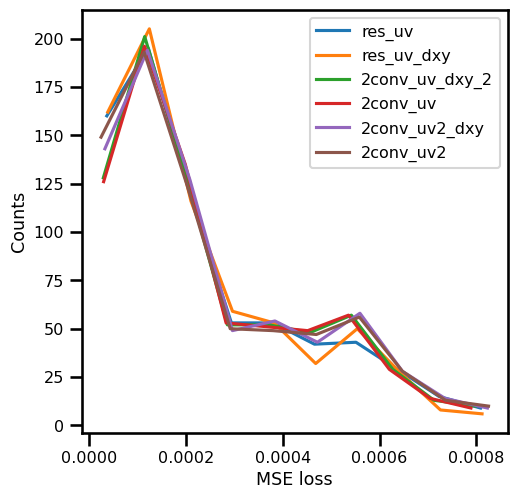

In [10]:
# histo of batches loss of the last epoch 
#f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
plt.rcParams["figure.figsize"] = [5.50, 5.50]
for sim in sims:
    bins,counts = np.histogram(sim.bloss/norm)
    plt.plot(counts[:-1],bins, label=sim.name)
    #print(sim.name)
plt.ylabel('Counts')
plt.xlabel('MSE loss')
plt.legend()

plt.show()

In [11]:
def multiplot_from_generator(g, num_columns, figsize_for_one_row=None):
    # call 'next(g)' to get past the first 'yield'
    next(g)
    # default to 15-inch rows, with square subplots
    if figsize_for_one_row is None:
        figsize_for_one_row = (12, 10/num_columns)
    try:
        while True:
            # call plt.figure once per row
            plt.figure(figsize=figsize_for_one_row)
            for col in range(num_columns):
                ax = plt.subplot(1, num_columns, col+1)
                next(g)
    except StopIteration:
        pass

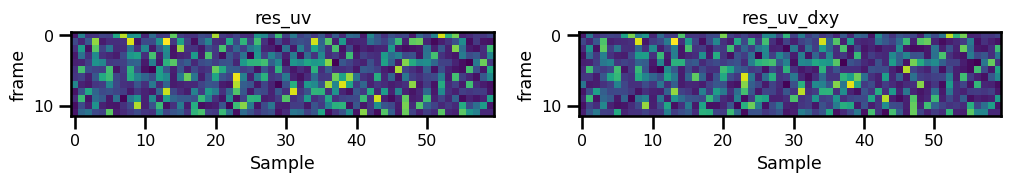

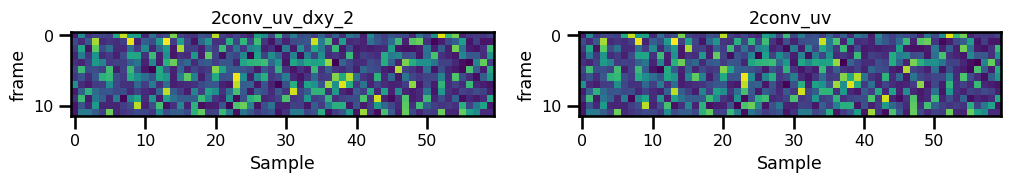

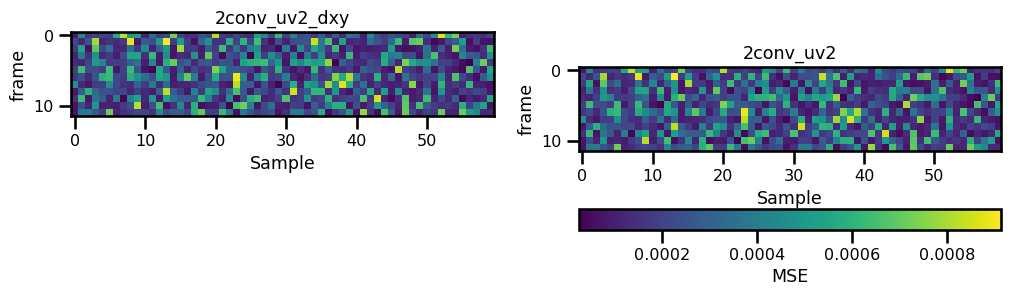

In [12]:
def demo_plot_and_yield():
    for sim in sims:
        yield
        #plt.plot(np.log(sim.tloss/norm),'r',np.log(sim.vloss/norm),'b')
        aa=sim.bloss/norm
        aa=np.concatenate((aa,aa.values[-1][None]),axis=0)
        aa=np.reshape(aa,(12,60))
        plt.imshow(aa, interpolation='nearest')
        plt.title(sim.name)
        plt.xlabel('Sample')
        plt.ylabel('frame')
        
multiplot_from_generator(demo_plot_and_yield(), 2)
cbar=plt.colorbar(label="MSE", orientation="horizontal")
#cbar.ax.set_xticklabels(rotation=90)
plt.show()

Here we run the config 2conv_uv_dxy each time with original dxy and by puting the latter to one.

2


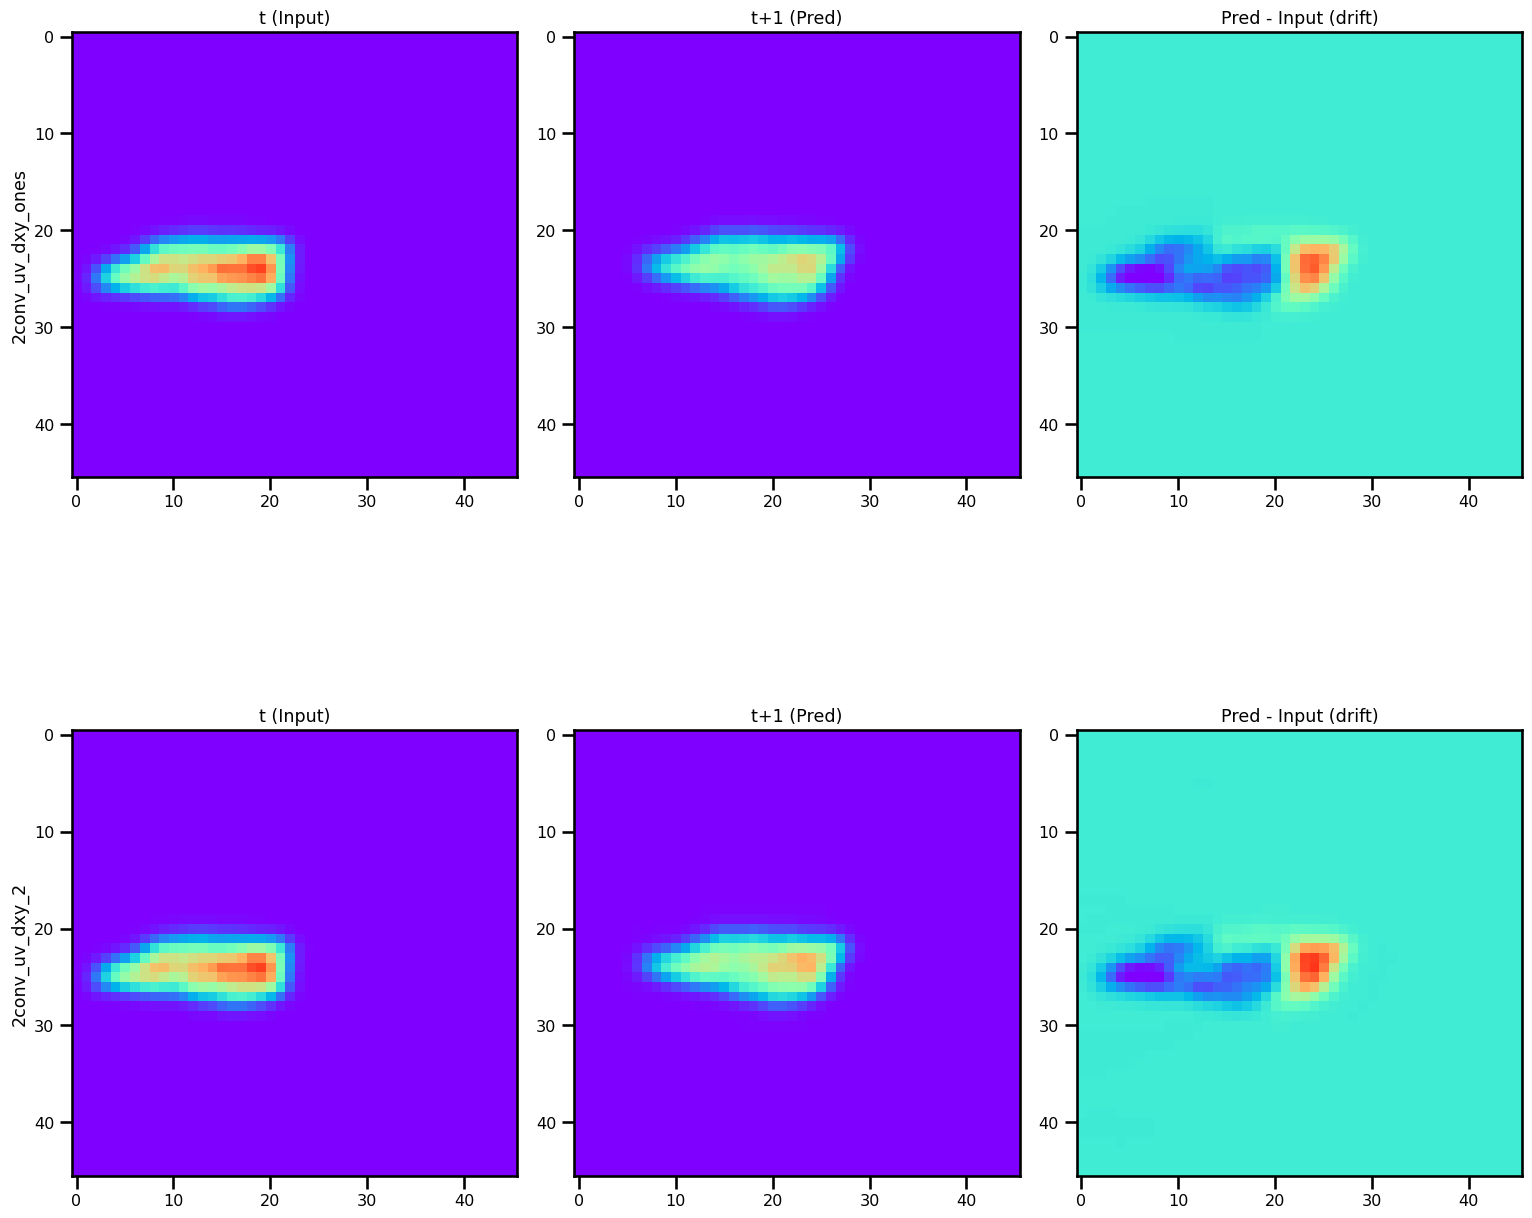

In [19]:

sns.reset_defaults()
sns.set_context("talk", font_scale=0.7)
class sim:
    def __init__(self, name, tloss, vloss, bloss):
        self.name  = name
        self.tloss = tloss
        self.vloss = vloss
        self.bloss = bloss
        
simulations={'2conv_uv_dxy_2', '2conv_uv_dxy_ones' }
data_path= '/home/anas/MEOM_Workspace/data/models/snapshot/UNet/'
sims1=[]

for simulation in simulations:
    name=simulation
    #print(data_path + name + 'loss.txt')
    edata= pd.read_csv(data_path + name + '/loss.txt', sep=",")
    bdata= pd.read_csv(data_path + name + '/Bloss.txt')
    tloss=edata["train_loss"]
    vloss=edata["val_loss"]
    bloss=bdata
    #print(bloss.shape)
    sims1.append(sim(name,tloss,vloss,bloss))


print(len(sims1))
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

j=10
file_in= data_path + sims1[0].name + '/maps.nc'
nc1 = xr.open_dataset(file_in)
x = nc1.density_map_gt.values[j,0,:,:]
ind = np.unravel_index(np.argmax(x, axis=None), x.shape)
#print([1:1:10])


plt.rcParams["figure.figsize"] = [15.50, 15.50]
#plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(len(sims1), 3)

""" Iterate column's axes"""
def iterate_columns(cols, x,ind,i, name):
    k=23
    mmax=0.6

    cols[0].imshow(x.density_map_gt.values[j1,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],
                   cmap=cm.rainbow, vmin=0, vmax=mmax)
    cols[0].title.set_text('t (Input)')
    cols[0].set_ylabel(name)
    cols[1].imshow(x.density_map_ml.values[j+1,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],
                    cmap=cm.rainbow, vmin=0, vmax=mmax)
    cols[1].title.set_text('t+1 (Pred)')
    cols[2].imshow(x.density_map_ml.values[j+1,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k]
                   -x.density_map_gt.values[j,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],
                    cmap=cm.rainbow, vmin=-0.3, vmax=0.5)
    cols[2].title.set_text('Pred - Input (drift)')
        

    
""" Iterate row's axes"""
i=0
u=1

for row in axes:
    file_in= data_path + sims1[i].name + '/maps.nc'
    nc1 = xr.open_dataset(file_in)
    nc1.density_map_ml.values[j+1,0,:,:]=nc1.density_map_ml.values[j+1,0,:,:]
    iterate_columns(row, nc1, ind, i, sims1[i].name)
    i=i+1
nc1 = xr.open_dataset(file_in)
x = nc1.density_map_ml.values[j,0,:,:]
plt.tight_layout()

plt.show()

